# Working with data that crosses the antimeridian
> History | Created Sep 2023

## Background
Many datasets use system where  longitude is numbered from -180 to +180 degrees east (see example below). This numbering system presets a problem for researchers working in a region that spans the antimeridian, because the data ends up on the opposite ends of the map.

<figure style="center" style="text-align: center">
  <img src="../images/map_-180to180.png" style="height:200px">
  <figcaption>Figure. Global map on -180/+180 longitude showing data region crossing the antimeridian.</figcaption>
</figure>


## Objectives  
This tutorial will demonstration how to use datasets with -180 to +180 latitude values to work within regions that cross the antimeridian. 

## The tutorial demonstrates the following techniques
- Downloading data that crosses the antimeridian from a dataset with -180 to +180 latitude values  
- Convert the data to a 0-360 latitude values
- Reordering the longitude axis so that the longitude values are in ascending order
- Visualizing data on a map

## Datasets used
__NOAA Chlorophyll Gap-filled, Blended NOAA-20 and S-NPP VIIRS, Science Quality, Global, 9km, 2018-
recent, Daily__  
This NOAA dataset blends chlorophyll data from, the Visible and Infrared Imager/Radiometer Suite (VIIRS) sensors aboard the Suomi-NPP and NOAA-20 spacecraft. The gaps in the data are them filled using a empirical orthogonal function (DINEOF). The dataset is avaialble from the CoastWatch Centeral ERDDAP: https://coastwatch.noaa.gov/erddap/griddap/noaacwNPPN20VIIRSSCIDINEOFDaily



### Import packages

In [15]:
import xarray as xr
import urllib.request   
import numpy as np
import pyproj  
from pyproj import CRS
from pyproj import Transformer as transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl

## Defined the area to extract
We will extract data for an area in the Bering Sea between Russia and the United States at 176°E to -152°E longitude and 50°N to 70°N latitude. 
<img src="../images/interest_area.png" style="height:200px">


### Set up variables
* Date to extract
* Minimum and maximum values for the longitude and latitude ranges.

In [104]:
my_date = '2023-08-18'
lon_min = -152.
lon_max = 176.
lat_min = 50.
lat_max = 70.

## Get the SeaWiFS data

### Open an xarray dataset object

In [109]:
url = 'https://coastwatch.noaa.gov/erddap/griddap/noaacwNPPN20VIIRSSCIDINEOFDaily'
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:    (time: 1869, altitude: 1, latitude: 2160, longitude: 4320)
Coordinates:
  * time       (time) datetime64[ns] 2018-05-30T12:00:00 ... 2023-08-19T12:00:00
  * altitude   (altitude) float64 0.0
  * latitude   (latitude) float32 89.96 89.88 89.79 ... -89.79 -89.88 -89.96
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
Data variables:
    chlor_a    (time, altitude, latitude, longitude) float32 ...
Attributes: (12/77)
    _lastModified:                    2023-08-30T21:15:06.000Z
    _NCProperties:                    version=2,netcdf=4.7.3,hdf5=1.12.0,
    cdm_data_type:                    Grid
    Conventions:                      CF-1.6, COARDS, ACDD-1.3
    creator_email:                    coastwatch.info@noaa.gov
    creator_name:                     NOAA CoastWatch
    ...                               ...
    testOutOfDate:                    now-4days
    time_coverage_end:                2023-08-19T12:00:00Z
    time_coverage_start:              2018-05-30T12:00:00Z
    title:                            Chlorophyll (Gap-filled DINEOF), NOAA S...
    Westernmost_Easting:              -179.9583
    westernmost_longitude:            -180.0

### Subset the data
We will do this in tow steps to make the process easier to follow.
1. Subset the data for date and latitude range
2. Subset the around the antimeridian
    * Request data < the limit (-152) on the US side of the antimeridian, i.e. -180 to -152
    * Request data > the limit (176) on the Russian side of the antimeridian, i.e. 176 to 180

In [110]:
# The lat1 and lat2 values are use in the slice function
# At first we set them as if the dataset is compliant with standards
lat1 = lat_min
lat2 = lat_max

# Then switch them if latitude values are descending
if ds.latitude[0].item() > ds.latitude[-1].item():
    lat1 = lat_max
    lat2 = lat_min

# Subset the data in two step to make it easier to understand
# 1. Subset the date and latitude range
ds_subset = ds['chlor_a'].sel(time=my_date, 
                              method='nearest').sel(latitude=slice(lat1, lat2))

# 2. Subset the around the antimeridian
ds_subset = ds_subset.sel(longitude=(ds.longitude < lon_min) | (ds.longitude > lon_max))

ds_subset

<xarray.DataArray 'chlor_a' (altitude: 1, latitude: 240, longitude: 384)>
[92160 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 2023-08-18T12:00:00
  * altitude   (altitude) float64 0.0
  * latitude   (latitude) float32 69.96 69.88 69.79 69.71 ... 50.21 50.12 50.04
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
Attributes: (12/13)
    C_format:               %.4g
    cell_methods:           time:mean(interval:1 day)
    colorBarMaximum:        30.0
    colorBarMinimum:        0.03
    colorBarScale:          Log
    coverage_content_type:  physicalMeasurement
    ...                     ...
    ioos_category:          Ocean Color
    long_name:              Chlorophyll Concentration, DINEOF Gap-Filled
    standard_name:          mass_concentration_of_chlorophyll_a_in_sea_water
    units:                  mg m^-3
    valid_max:              100.0
    valid_min:              0.001

## Plot the downloaded data


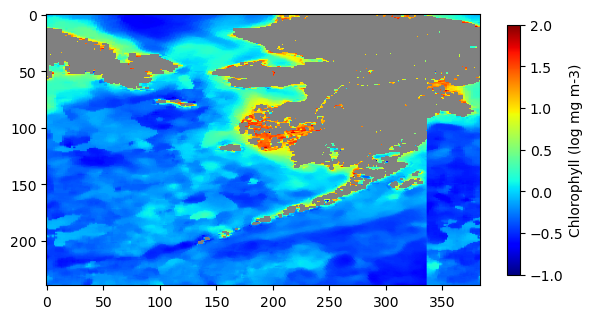

In [140]:
# Make plot area
fig, ax = plt.subplots(figsize=(7, 5))

# Set the color palette
cmap = mpl.cm.get_cmap("jet").copy()
cmap.set_bad(color='gray')

# show image
shw = ax.imshow(np.log10(ds_subset.squeeze()), cmap=cmap, vmin=-1, vmax=2)

bar = plt.colorbar(shw, shrink=0.65)
  
# show plot with labels
#plt.xlabel('X Grid (m)')
#plt.ylabel('Y Grid (m)')
bar.set_label('Chlorophyll (log mg m-3)')
plt.show()

### The plot of the data shows a discontinuity
The plot of subsetted data (above) shows that we downloaded the data we requested, but there a discontinuity on the right side of the map. The data from the Russian side (west of the antimeridian) is mapped to the east of the data on US side.   

To fix the discontinuity, we need to:   
* Change the longitude values on the US side of the antimeridian (-180 to -152) to values on the 0-360 longitude numbering system (180-208).
* Rearrange the longitude values so that the data on the Russian side is move to the west of the data on the US side.

## Change to 0-360 longitude numbering

In [184]:
ds_360 = ds_subset.assign_coords(longitude=(ds_subset.longitude % 360))

print('minimum lat value =', ds_360.longitude.min().item())
print('minimum lat value =', ds_360.longitude.max().item(), end='\n\n')

print('first value in lat array =', ds_360.longitude[0].item())
print('last value in lat array =', ds_360.longitude[-1].item())

minimum lat value = 176.0416717529297
minimum lat value = 207.9583282470703

first value in lat array = 180.0416717529297
last value in lat array = 179.95834350585938


## Reorder the longitude axis
The output from the cell above shows that the latitude values have been converted to 0-360. However, the lowest latitude value is not at the beginning of the array and the highest latitude value is not a the end of the array.

To rearrange the longitude values, use the roll function of xarray. The roll function will push values along an axis by the number of steps you enter. The values that are "pushed off" of the end of the array will be put at the beginning of the array.   

* First we need to find where on the longitude discontinuity happens, i.e. where the most easterly longitude (208.0) abruptly meets the most easterly longitude value (176.0)
* Next, use the discontinuity position to determine how many position the roll the longitude array to the right. Apply the number to the roll function. 


In [212]:
# This code finds the index where the absolute value between each longitude value 
# and the minimal latitude value is maximal
discont_index = max(range(len(ds_360.longitude)), key=lambda i: abs(ds_360.longitude[i] - ds_360.longitude.max()))
print('the index marking the discontinuity is:', discont_index, end='\n\n')

# Substract the discontinuity position from the length of the array 
# to obtain the number of positions to roll the longitude axis
postions_to_roll = len(ds_360.longitude) - discont_index

# Roll the dataset
ds_rolled = ds_360.roll(longitude=postions_to_roll, roll_coords=True)

print('minimum lat value =', ds_rolled.longitude.min().item())
print('minimum lat value =', ds_rolled.longitude.max().item(), end='\n\n')

print('first value in lat array =', ds_rolled.longitude[0].item())
print('last value in lat array =', ds_rolled.longitude[-1].item())


the index marking the discontinuity is: 336

minimum lat value = 176.0416717529297
minimum lat value = 207.9583282470703

first value in lat array = 176.0416717529297
last value in lat array = 207.9583282470703


The output from the cell above shows that the latitude values have been converted to 0-360, and that the lowest latitude value is at the beginning of the array and the highest latitude value is at the end of the array.

## Plot the data
#### The discontinuity has been corrected! 

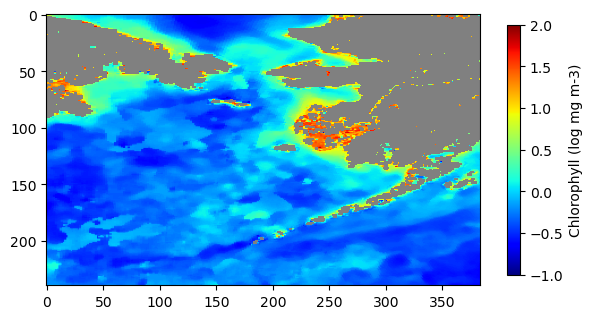

In [209]:
# Make plot area
fig, ax = plt.subplots(figsize=(7, 5))

# Set the color palette
cmap = mpl.cm.get_cmap("jet").copy()
cmap.set_bad(color='gray')

# show image
shw = ax.imshow(np.log10(ds_rolled.squeeze()), cmap=cmap, vmin=-1, vmax=2)

bar = plt.colorbar(shw, shrink=0.65)
  
# show plot with labels
#plt.xlabel('X Grid (m)')
#plt.ylabel('Y Grid (m)')
bar.set_label('Chlorophyll (log mg m-3)')
plt.show()


## Save the corrected dataset as a netCDF file

In [213]:
ds_rolled.to_netcdf('data_corrected_0_to_360.nc')